# Week 5 - Semantic & Influence Networks

Assignment by Chu Zhuang

In [4]:
#Special module written for this class
#This provides access to data and to helper functions from previous weeks
#Make sure you update it before starting this notebook
import lucem_illud_2020 #pip install -U git+git://github.com/Computational-Content-Analysis-2020/lucem_illud_2020.git

#All these packages need to be installed from pip

#This will be doing most of the work
import networkx as nx

import sklearn #For generating some matrices
import pandas as pd #For DataFrames
import numpy as np #For arrays
import matplotlib.pyplot as plt #For plotting
import seaborn #Makes the plots look nice
import scipy #Some stats
import nltk #a little language code
from IPython.display import Image #for pics

import pickle #if you want to save layouts
import os

%matplotlib inline

This is a new copora for my final project, which records social interaction between two people when they are trying to 'debate/discuss' a moral problem in an experiment setting. Two conditions are manipulated in this experiment: 1) one is **Thank you because**: Person A was instructed to respond with gratitude and understanding of Person B's statement before sharing his/her own, for example,--'thank you for sharing your opinion, because I think...'; 2) the other one is **No because**: Person A was instructed to respond with negation and stated her opinion directly, for example, 'No..I think..because'. This study wants to see whether showing gratitude could help people better understand each other's view point and reach an agreement. 

In the content analysis for the final project, we hope to first of all analze the degree of 'gratitude' in the conversation corpora from linguistic features, by annotation, and examine the degree of 'gratitude'expresed in the corpora in each condition and each pair. 

Currently, we obtain a copora of 12 pairs'conversation and organize them into a Dataframe, to record both the conversation text, experiment condition, and also the texts for each Person A and Person B, shown as below:

First of all, load our corpora and do basic text pre-processing (e.g. tokenization, normalization, and filtering stopwords).

In [122]:
#load our corpor
df_con=pd.read_csv('com_corpora.csv') 

In [123]:
#function for sentence tokenization
import spacy
nlp = spacy.load("en")

def sent_tokenize(word_list):
    doc = nlp(word_list)
    sentences = [sent.string.strip() for sent in doc.sents]
    return sentences

In [390]:
stop_words_freq=['the','a','it','that','to','of','is',"n't",'do',"'s'",'be','in']

#function for normalization
def normalizeTokens(word_list, extra_stop=stop_words_freq):
    #We can use a generator here as we just need to iterate over it
    normalized = []
    if type(word_list) == list and len(word_list) == 1:
        word_list = word_list[0]

    if type(word_list) == list:
        word_list = ' '.join([str(elem) for elem in word_list]) 

    doc = nlp(word_list.lower())
    
    # add the property of stop word to words considered as stop words
    if len(extra_stop) > 0:
        for stopword in extra_stop:
            lexeme = nlp.vocab[stopword]
            lexeme.is_stop = True

    for w in doc:
        # if it's not a stop word or punctuation mark, add it to our article
        if w.text != '\n' and not w.is_stop and not w.is_punct and not w.like_num and len(w.text.strip()) > 0:
            # we add the lematized version of the word
            if w.lemma_!='-PRON-':
                normalized.append(str(w.lemma_))

    return normalized

In [391]:
#tokenize, normalize, and normalize based on sentences
df_con['tokenized_text_all'] = df_con['conversation_txt'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_con['tokenized_text_A'] = df_con['con_txt_A'].apply(lambda x: lucem_illud_2020.word_tokenize(x))
df_con['tokenized_text_B'] = df_con['con_txt_B'].apply(lambda x: lucem_illud_2020.word_tokenize(x))

df_con['normalized_token_all'] = df_con['tokenized_text_all'].apply(lambda x: normalizeTokens(x))
df_con['normalized_token_A'] = df_con['tokenized_text_A'].apply(lambda x: normalizeTokens(x))
df_con['normalized_token_B'] = df_con['tokenized_text_B'].apply(lambda x: normalizeTokens(x))

In [392]:
df_con['sentences_all'] = df_con['conversation_txt'].apply(lambda x: [normalizeTokens(s) for s in sent_tokenize(x)])
df_con['sentences_A'] = df_con['con_txt_A'].apply(lambda x: [normalizeTokens(s) for s in sent_tokenize(x)])
df_con['sentences_B'] = df_con['con_txt_B'].apply(lambda x: [normalizeTokens(s) for s in sent_tokenize(x)])

In [755]:
df_con['word_counts'] = df_con['normalized_token_all'].apply(lambda x: len(x))
df_con['word_counts_A'] = df_con['normalized_token_A'].apply(lambda x: len(x))
df_con['word_counts_B'] = df_con['normalized_token_B'].apply(lambda x: len(x))

In [393]:
df_con.head()

,Unnamed: 0,condition,conversation_txt,con_txt_A,con_txt_B,tokenized_text_all,tokenized_text_A,tokenized_text_B,normalized_token_all,normalized_token_A,normalized_token_B,sentences_all,sentences_A,sentences_B,word_counts
0,0,NB,"Okay, so uh, I guess they said we should start...","Okay, so uh, I guess they said we should start...","Yea, we should start Um, yeah. I actually didn...","[Okay, so, uh, I, guess, they, said, we, shoul...","[Okay, so, uh, I, guess, they, said, we, shoul...","[Yea, we, should, start, Um, yeah, I, actually...","[okay, uh, guess, say, start, yea, start, uh, ...","[okay, uh, guess, say, start, uh, say, topic, ...","[yea, start, um, yeah, actually, look, legal, ...","[[okay, uh, guess, say, start], [yea, start], ...","[[okay, uh, guess, say, start], [uh, say, topi...","[[yea, start, um], [yeah], [actually, look, le...",592
1,1,TYB,"So I don't really I think I said--yes, everyon...","So I don't really I think I said--yes, everyon...",I-I think put something that's below five.. Th...,"[So, I, do, n't, really, I, think, I, said, ye...","[So, I, do, n't, really, I, think, I, said, ye...","[I, I, think, put, something, that, 's, below,...","[think, say, yes, think, oh, okay, uhhm, think...","[think, say, yes, oh, okay, uhhm, think, reaso...","[think, yeah, like, quote, bit, debate, mean, ...","[[], [think, said--], [yes], [i-], [think], [o...","[[], [think, said--], [yes], [oh, okay, uhhm],...","[[], [-i, think], [], [], [yeah, like, quote],...",393
2,2,NB,"Uh, so, uh I-I actually uh read a lot about th...",Ok and so what does the law say? Does it say l...,"Uh, so, uh I-I actually uh read a lot about th...","[Uh, so, uh, I, I, actually, uh, read, a, lot,...","[Ok, and, so, what, does, the, law, say, Does,...","[Uh, so, uh, I, I, actually, uh, read, a, lot,...","[uh, uh, actually, uh, read, lot, topic, uh, u...","[ok, law, like, study, ok, umm, thing, think, ...","[uh, uh, actually, uh, read, lot, topic, uh, u...","[[uh, uh], [-i, actually, uh, read, lot, topic...","[[ok], [law], [like, study], [ok, umm, thing, ...","[[uh, uh], [-i, actually, uh, read, lot, topic...",348
3,3,TYB,Okay so you--What's your opinion on this? I st...,Okay so you--What's your opinion on this? Oh w...,I strongly disagree with this I think you shou...,"[Okay, so, you, What, 's, your, opinion, on, t...","[Okay, so, you, What, 's, your, opinion, on, t...","[I, strongly, disagree, with, this, I, think, ...","[okay, opinion, strongly, disagree, oh, wow--,...","[okay, opinion, oh, wow--, okay, mean, like, c...","[strongly, disagree, think, able, walk, red, l...","[[okay], [opinion], [strongly, disagree], [oh,...","[[okay], [opinion], [oh, wow--], [okay], [], [...","[[strongly, disagree, think, able, walk, red, ...",550
4,4,TYB,"I'm good whenever you are Okay, let's start, y...","Okay, let's start, yea [laugh] Yeah, so um I t...","I'm good whenever you are So I guess like, wha...","[I, 'm, good, whenever, you, are, Okay, let, '...","[Okay, let, 's, start, yea, laugh, Yeah, so, u...","[I, 'm, good, whenever, you, are, So, I, guess...","[m, good, okay, let, start, yea, laugh, guess,...","[okay, let, start, yea, laugh, yeah, um, think...","[m, good, guess, like, wha, wha, think, um, gu...","[[good, okay, let, start, yea, laugh], [guess,...","[[okay, let, start, yea, laugh], [yeah, um, th...","[[good], [guess, like, wha], [-wha], [-what, t...",230


## <span style="color:red">*Exercise 1*</span>

<span style="color:red">Construct cells immediately below this that render networks to meaningfully characterize the structure of words and documents (or subdocuments like chapters or paragraphs) from your corpus. What are useful filters and thresholds and what semantic structures do they reveal that give insight into the social world and social game inscribed in your corpus? Interrogate interesting subgraphs of your network and detail what they reveal about the semantic space involved.

First, build a graph based on word cooccurences in all of the 12 corpora/conversations we have:

In [330]:
#wordcococurrence functions
def wordCooccurrence(sentences, makeMatrix = False):
    words = set()
    for sent in sentences:
        words |= set(sent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in sentences:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        return g

In [394]:
g = wordCooccurrence(df_con['normalized_token_all'].sum())

Total number of vertices:

In [395]:
len(g.nodes)

31

In [396]:
len(g.edges)

354

A part of the adjacency matrix of cleaned word by corpora:

In [397]:
#since here are only 12 corpora, we do not do indicing here 
nx.to_numpy_matrix(g)

matrix([[ 68., 171., 157., 140.,  24.,  41.,   2.,   0.,   1.,   0.,
          69., 137.,  50.,  44.,  22.,   2.,   5.,   1.,  77., 168.,
           3.,   0.,   5.,  63.,  35.,  47.,   8.,  99.,  20.,   2.,
         110.],
        [171., 168., 268., 455.,  93., 194.,   2.,   1.,   1.,   2.,
         234., 420., 192., 150., 111.,  56.,  10.,  10.,  98., 439.,
           3.,   8.,  20.,  63., 113., 209.,  32., 103.,  20.,   2.,
         129.],
        [157., 268., 110., 519., 109., 171.,   0.,   9.,   0.,   4.,
         150., 204., 273., 181., 105.,  33.,  43.,   5., 250., 213.,
           0.,   0.,  69.,  93., 120., 224.,  23.,  44.,  24.,   0.,
          80.],
        [140., 455., 519., 748., 198., 438.,   0.,   8.,   3.,   1.,
         342., 484., 782., 308., 172., 153.,  16.,  37., 213., 740.,
           3.,  25.,  75., 152., 388., 502., 137., 351.,  37.,   0.,
         197.],
        [ 24.,  93., 109., 198.,  22.,  51.,   0.,   1.,   0.,   0.,
          79., 131.,  43.,  47.,  18., 

Then, we try to build a two-mode network graph, containing both word and document: 

In [398]:
def tokenize(text):
    tokenlist = lucem_illud_2020.word_tokenize(text)
    normalized = normalizeTokens(tokenlist)  #check if this works
    return normalized

In [578]:
#import functions for feature extraction
import sklearn.feature_extraction

In [399]:
senVectorizer = sklearn.feature_extraction.text.CountVectorizer(tokenizer = tokenize)
senVects_incidence = senVectorizer.fit_transform(df_con['conversation_txt'])

In [400]:
senVects_incidence.shape

(12, 583)

Build the 2-mode graph, for both words and document:

In [401]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [402]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 595
Number of edges: 972
Average degree:   3.2672


Plot the bipartite network with a quick spring layout:

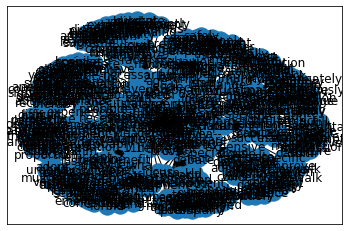

In [375]:
nx.draw_networkx(g_2mode)

It is very crowded! Then, we delete some low-weight edges and isolated nodes for better visualization:

* remove edges which has weights less than 5;
* remove isolated node;
* find the giant, most connected graph.

In [403]:
g_2mode.remove_edges_from([(n1, n2) for n1, n2, d in g_2mode.edges(data = True) if d['weight'] <= 4])

In [404]:
g_2mode.remove_nodes_from(list(nx.isolates(g_2mode))) #since we are changing the graph list() evaluates the isolates first

In [405]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 41
Number of edges: 71
Average degree:   3.4634


Also try to find the gaint connected subgraph (since the isolated nodes are excluded, the graph should be the same as the exclude one):

In [406]:
def connected_component_subgraphs(G):
    for c in nx.connected_components(G):
        yield G.subgraph(c)

In [407]:
giant = max(connected_component_subgraphs(g_2mode), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 41
Number of edges: 71
Average degree:   3.4634


Plot the 2-mode graph: From the graph below, we could see more clearly that the most frequent words **{'think','like','yeah','People'}** we found in the last homework also appeared central in this graph, connect closely with all the others corpora/document.

For documents, corpora 5/8/9 are centrallly close to each other, which all fall into the TYB condition. The corpora 11 is relatively far from the central positions, which might be resulted from the relative small number of words in the corpora (~271 words).  

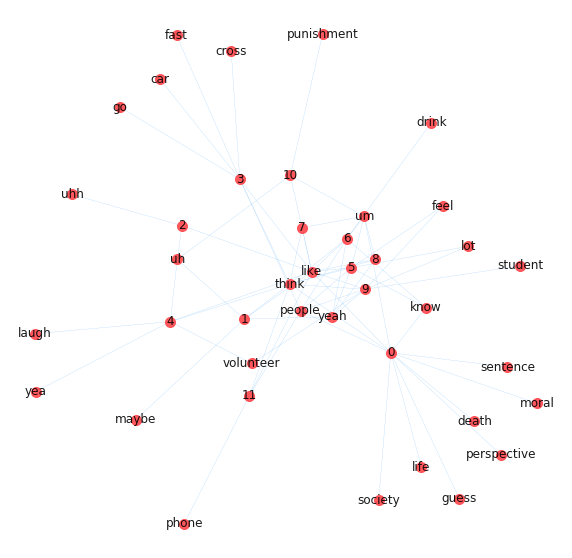

In [408]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

In [581]:
df_con[['condition','word_counts']]

,condition,word_counts
0,NB,592
1,TYB,393
2,NB,348
3,TYB,550
4,TYB,230
5,TYB,654
6,NB,510
7,NB,374
8,TYB,229
9,TYB,507


### Two mode to One mode:

A two-mode network can be easily transformed into two one-mode network, enabling words to be connected to other words via the number of documents that share them, or documents to be connected to other documents via the words they share:

In [386]:
#transfer into a one-mode network
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [409]:
gDoc = contractNetwork(g_2mode, 'doc')

Let's first take a look at the document-to-document network:

In [410]:
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 12
Number of edges: 66
Average degree:  11.0000


Let's construct a visualization: 

It is not surprising that almost every document is connected to every other. since the small number of corpora/document we have, the graph is already very clear before trimming. In the graph, document 0,5,6 are at the central positions in the graph, which are corpora of **higher numbers of words**; while the experiment condition does not impact the positions of nodes or patterns of the graph. 

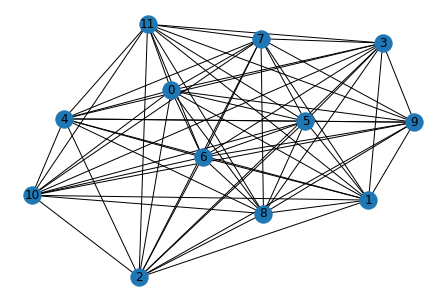

In [411]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

In [28]:
df_con[['condition','word_counts']]

,condition,word_counts
0,NB,592
1,TYB,393
2,NB,348
3,TYB,550
4,TYB,230
5,TYB,654
6,NB,510
7,NB,374
8,TYB,229
9,TYB,507


Then, take a look at the word-by-word, 1-mode graph:

In [412]:
gWord = contractNetwork(g_2mode, 'word')
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 29
Number of edges: 147
Average degree:  10.1379


In [413]:
wMean = np.mean([d['weight'] for n1, n2, d in gWord.edges(data = True)])
wMean

1.4489795918367347

In [582]:
#remove the isolated words
gWord.remove_nodes_from(list(nx.isolates(gWord)))

In [415]:
print(nx.info(gWord))

Name: 
Type: Graph
Number of nodes: 29
Number of edges: 147
Average degree:  10.1379


Then, visualize the word-by-word graph:

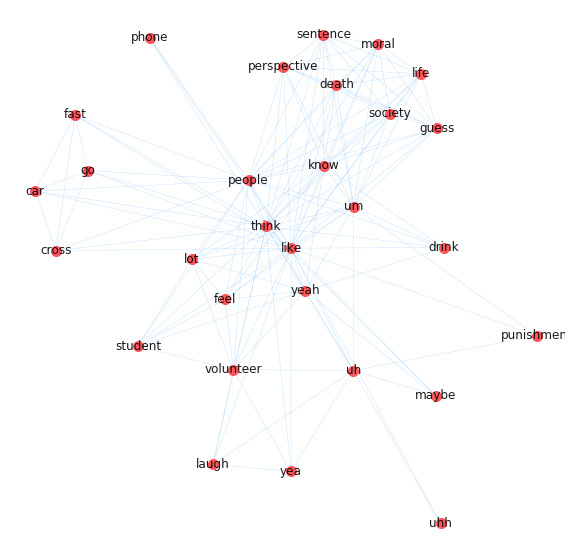

In [416]:
layout = nx.spring_layout(gWord, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gWord, ax = ax, pos = layout, labels = {n:n for n in gWord.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

As we could see from above, the word-by-word graph based on document co-occurance also revealed the most frequent words in the dataset: **{like, think, yeah, feel, um, uh, people, say}**, which corresponds with the central words in the 2-mode graph. These words are not only most frequently used, but also of interests in the whole dataset as well (yeah, um, uh), which might reveal the attidues of speakers in the conversation, while the relationship between thses most frequent words might not be that important. 

In the graph, there are also other sub-clusters which are related with the topic of these coprpus: 1) car-go-fast, related with 'whether people should cross the street when the signal is red'; 2) death-moral-sentence, for 'whether we should have death penalty.', which indeed revealed meaningful semantic structures.

Then, we try to find the most connected sub-graph by words and words, actually it is the same graph as the orginal one.

In [590]:
giant = max(connected_component_subgraphs(gWord), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 29
Number of edges: 147
Average degree:  10.1379


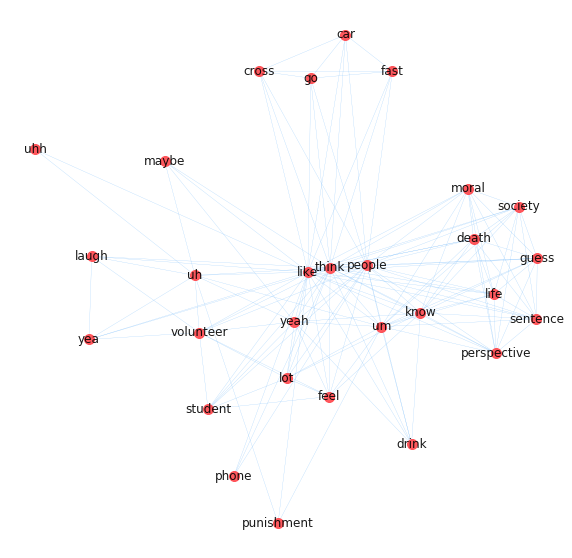

In [591]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

Then, we also try to draw the word-by-word graph based on co-occurence by sentences:

In [232]:
g = wordCooccurrence(df_con['sentences_all'].sum())

In [236]:
#remove edges less than 6
g.remove_edges_from([(n1, n2) for n1, n2, d in g.edges(data = True) if d['weight'] <= 5])

In [237]:
g.remove_nodes_from(list(nx.isolates(g))) 

In [238]:
print(nx.info(g))

Name: 
Type: Graph
Number of nodes: 107
Number of edges: 153
Average degree:   2.8598


Visualization: as we could see below, the graph based on word co-occurence by sentence is not very interesting, since the most frequent word appear by sentence is 'like', which is at central and connects to all the other words, like a **'star'** graph and is less meaningful.

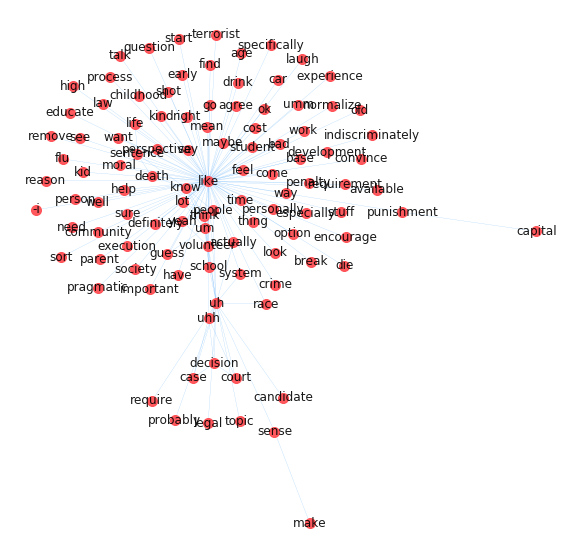

In [239]:
layout = nx.spring_layout(g, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(g, ax = ax, pos = layout, labels = {n:n for n in g.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

#### More about community
Let us use this oppurtunity to introduce a concept of finding communities in graphs: a popular one is the modularity measure, introduced in: Clauset, A., Newman, M. E., & Moore, C. “Finding community structure in very large networks.” Physical Review E 70(6), 2004.

networkx implements this through the above method. It yields sets of nodes, one for each community.

In [240]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(giant))

In [254]:
c[0]

frozenset({'actually',
           'age',
           'agree',
           'bad',
           'base',
           'break',
           'candidate',
           'car',
           'case',
           'childhood',
           'come',
           'community',
           'convince',
           'cost',
           'court',
           'crime',
           'death',
           'decision',
           'definitely',
           'development',
           'drink',
           'early',
           'educate',
           'encourage',
           'especially',
           'execution',
           'feel',
           'find',
           'flu',
           'go',
           'guess',
           'have',
           'help',
           'important',
           'kid',
           'kind',
           'know',
           'law',
           'life',
           'like',
           'look',
           'lot',
           'make',
           'maybe',
           'mean',
           'moral',
           'need',
           'normalize',
           'ok',
 

Moreover, we can find cliques, or completely connected sets of nodes: 

as we could see from below, the cliques cover both interesting **frequent** words: *like, think, um, know*; but also those centered around **topics**: *death, society, life, etc*, which is correspond with the visualzation in the word-by-word graph.

In [592]:
print(', '.join(max(nx.clique.find_cliques(giant), key = lambda x: len(x))))

like, think, people, um, know, guess, society, death, perspective, sentence, moral, life


#### Subgraph centered around word:

Now lets look at a subgraph of the network, those nodes that are within 1 or 2 network steps of 'like'-the most frequent word: 

In [593]:
likeNeighbors = giant.neighbors('like')
g_like = giant.subgraph(likeNeighbors)
print(nx.info(g_like))

Name: 
Type: Graph
Number of nodes: 28
Number of edges: 119
Average degree:   8.5000


It seems like the words centering around 'like' are just those words most frequently appeared, centering in the word-by-word graph. 

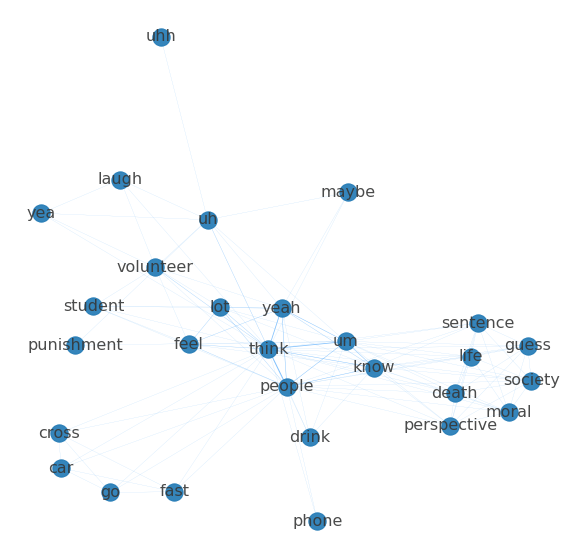

In [594]:
layout_amer = nx.spring_layout(g_like, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_like.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_like.edges(data = True)))
nx.draw(g_like, ax = ax, pos = layout_amer, labels = {n:n for n in g_like.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_like.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

Then we try to find the network around 'Yeah', compared with 'like', the graph is much smaller, which makes sense, since 'yeah' appears less in the corpora than 'like; and the nodes are also the most frequent words in the corpora.

In [595]:
yeahNeighbors = giant.neighbors('yeah')
g_yeah = giant.subgraph(yeahNeighbors)
print(nx.info(g_yeah))

Name: 
Type: Graph
Number of nodes: 12
Number of edges: 44
Average degree:   7.3333


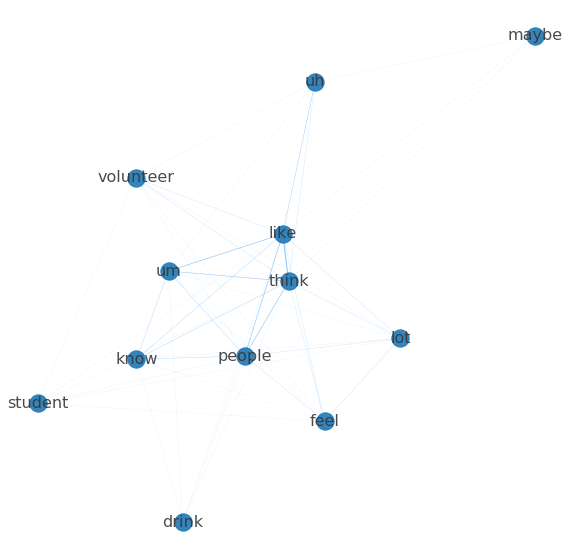

In [596]:
layout_amer = nx.spring_layout(g_yeah, weight='weight', iterations= 100, k = .3)
fig, ax = plt.subplots(figsize = (10,10))
maxWeight = max((d['weight'] for n1, n2, d in g_yeah.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in g_yeah.edges(data = True)))
nx.draw(g_yeah, ax = ax, pos = layout_amer, labels = {n:n for n in g_yeah.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in g_yeah.edges(data = True)], 
        alpha = .9, 
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:sky blue',
        cmap = plt.get_cmap('plasma')) 

# Network Statistics
We can often gain more insight into our semantic network through statistics that describe the positions of words within it.

We begin with measures of centrality. The concept of centrality is that some nodes (words or documents) are more *central* to the network than others. The most straightforward is the notion of degree centrality: those nodes that have the highest number of connections are the most central. Here our measure normalizes the number of connections by those with the most connections.

In [423]:
dcentralities = nx.degree_centrality(giant)

In [424]:
dcentralities['like']

1.0

Not surprisingly, the node of maximum degree centrality is 'like':

In [601]:
max(dcentralities.items(), key = lambda x : x[1])

('like', 1.0)

In [426]:
dcentralities['know']

0.5357142857142857

In [602]:
dcentralities['yeah']

0.42857142857142855

In [427]:
dcentralities['society']

0.39285714285714285

We can color and size the nodes by degree centrality: as we could see the most frequent words shown in the documents, are also the one with highest degree centrality: 'like','think','people','um','know'. Also for the 'death sentence' group, they also very moderate degree centraility, maybe caused by it small subgroup of related words.

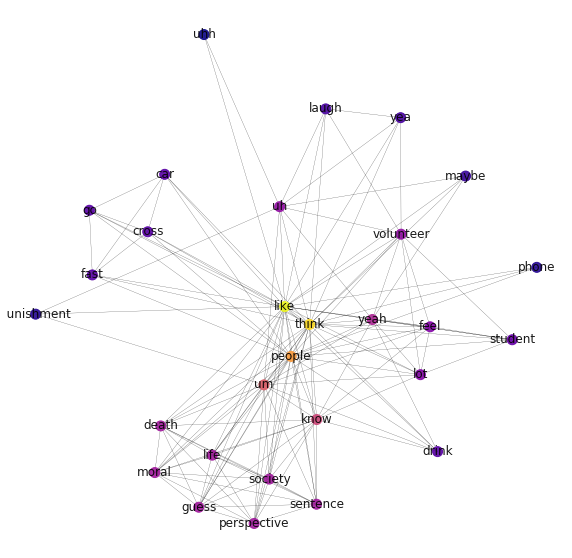

In [428]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Another way to visualize the graph involes the use of size to represent degree centrality and edge weight: it is more clear that the most frequent words have highest degree centrality.

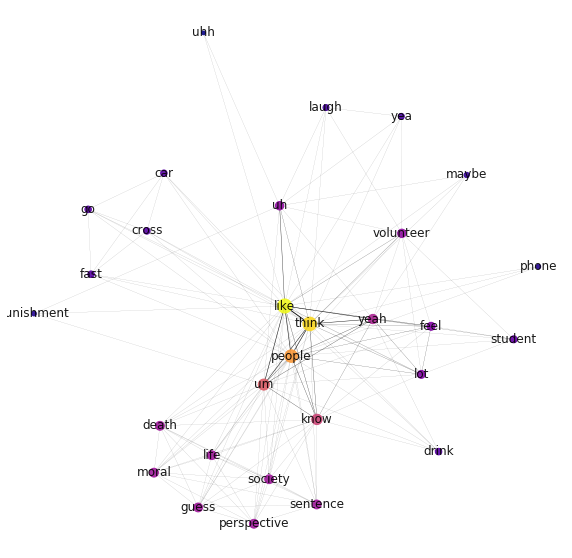

In [429]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(dcentralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gWord.edges(data = True)], 
        alpha = .9, 
        node_color = [dcentralities[n] / maxC for n in giant.nodes],
        node_size = [dcentralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of degree centrality is: it might because of the relative small corpora, especially after normalization; the distribution trend of decreasing is not very clear. 

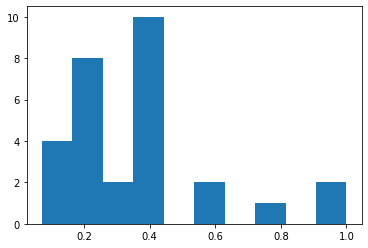

In [430]:
plt.hist(list(dcentralities.values()))
plt.show()

Nodes of highest degree centrality: 1) frequent communication words; 2) words topic related: 'death','moral','life'.

In [431]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('like', 1.0),
 ('think', 0.9285714285714285),
 ('people', 0.7857142857142857),
 ('um', 0.6071428571428571),
 ('know', 0.5357142857142857),
 ('yeah', 0.42857142857142855),
 ('death', 0.39285714285714285),
 ('guess', 0.39285714285714285),
 ('life', 0.39285714285714285),
 ('moral', 0.39285714285714285)]

In [432]:
sorted(dcentralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('cross', 0.21428571428571427),
 ('drink', 0.21428571428571427),
 ('fast', 0.21428571428571427),
 ('go', 0.21428571428571427),
 ('laugh', 0.17857142857142855),
 ('yea', 0.17857142857142855),
 ('maybe', 0.14285714285714285),
 ('phone', 0.10714285714285714),
 ('punishment', 0.10714285714285714),
 ('uhh', 0.07142857142857142)]

Consider another very different measure, which is *betweenness* centrality. Betweenness centrality distinguishes nodes that require the most shortest pathways between all other nodes in the network. Semantically, words with a high betweenness centrality may link distinctive domains, rather than being "central" to any one. In other words, high *betweenness centrality* nodes may not have the highest *degree centrality*.

In [604]:
centralities = nx.betweenness.betweenness_centrality(giant)

In [605]:
centralities['like']

0.28551902242378435

The word of maximum betweenness centrality is also 'like'.

In [606]:
max(centralities.items(), key = lambda x : x[1])

('like', 0.28551902242378435)

Then, we can color and size the nodes by betweenness centrality: looks very similar to the degree centrality graph as well.

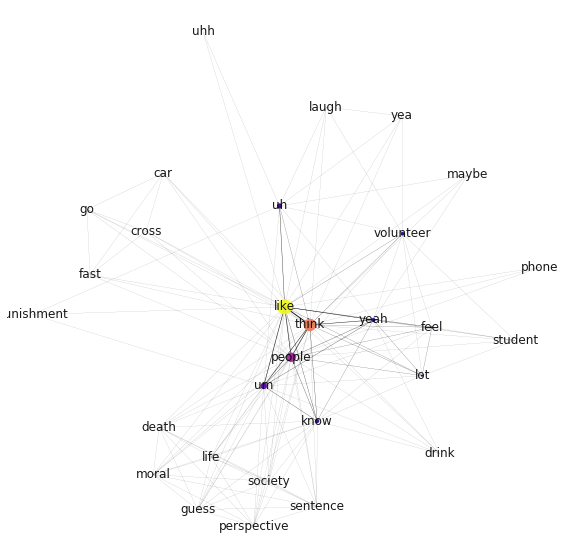

In [436]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

The distrubution of betweenness centrality is: more words have small degree of betweeness, most words are not closely connected with each other.

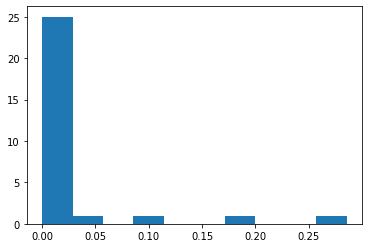

In [608]:
plt.hist(list(centralities.values()))
plt.show()

What are the top ten words in terms of betweenness?  More communication words appear now, since the topic related words are more clustered together. The betweenness of the **nodes in those subgroup** (e.g. 'death penalty group') is relatively small, which is different from degree centrality. The communication words are real 'bridging' word in the dialogue.

In [440]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('like', 0.28551902242378435),
 ('think', 0.188517258755354),
 ('people', 0.10073066263542453),
 ('um', 0.042416225749559076),
 ('uh', 0.024187452758881327),
 ('know', 0.015696649029982364),
 ('yeah', 0.0140904509952129),
 ('volunteer', 0.01062610229276896),
 ('feel', 0.0017006802721088433),
 ('lot', 0.0017006802721088433)]

The 'moral','society','sentence' words which have high degree centrality, but only appear together in subgroups now have relative lower betweeness centrality.

In [443]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('maybe', 0.0),
 ('moral', 0.0),
 ('perspective', 0.0),
 ('phone', 0.0),
 ('punishment', 0.0),
 ('sentence', 0.0),
 ('society', 0.0),
 ('student', 0.0),
 ('uhh', 0.0),
 ('yea', 0.0)]

We can also look at closeness centrality, or the average Euclidean or path distance between a node and all others in the network. A node with the highest closeness centrality is most likely to send a signal with the most coverage to the rest of the network.

In [609]:
centralities = nx.closeness_centrality(giant)

As we could see from the words of top closeness centrality and the graph below, the result of closeness centrality is very close to that of degree centrality.  

In [446]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('like', 1.0),
 ('think', 0.9333333333333333),
 ('people', 0.8235294117647058),
 ('um', 0.717948717948718),
 ('know', 0.6829268292682927),
 ('yeah', 0.6363636363636364),
 ('death', 0.6222222222222222),
 ('guess', 0.6222222222222222),
 ('life', 0.6222222222222222),
 ('moral', 0.6222222222222222)]

In [447]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('cross', 0.56),
 ('drink', 0.56),
 ('fast', 0.56),
 ('go', 0.56),
 ('laugh', 0.5490196078431373),
 ('yea', 0.5490196078431373),
 ('maybe', 0.5384615384615384),
 ('phone', 0.5283018867924528),
 ('punishment', 0.5283018867924528),
 ('uhh', 0.5185185185185185)]

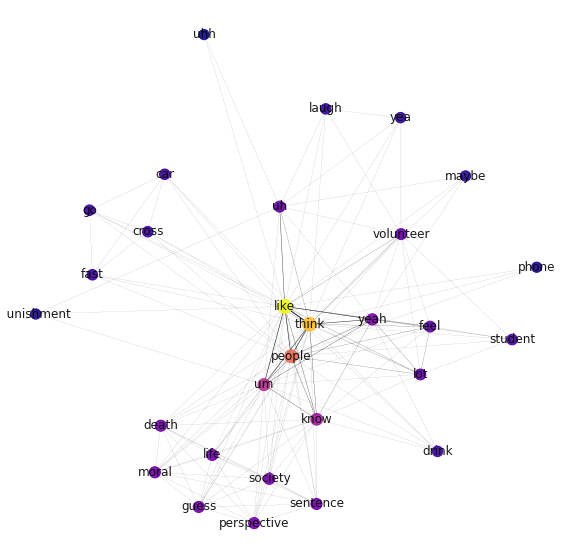

In [445]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

Or eignvector centrality, an approach that weights degree by the centrality of those to whom one is tied (and the degree to whom they are tied, etc.) In short, its an $n$th order degree measure.

In [448]:
centralities = nx.eigenvector_centrality(giant)

As we could see below, this measure of centrality is very close to degree centrality; while since it also takes into account the scores of its connecting nodes, the eigenvector centrality of those locally closely clustered group are very high as well:

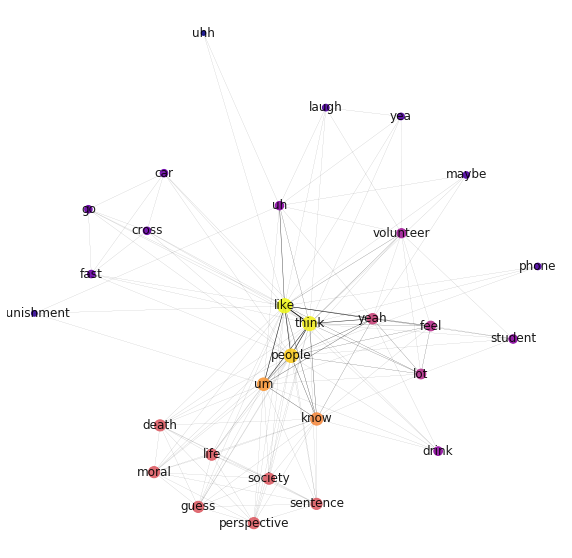

In [449]:
fig, ax = plt.subplots(figsize = (10,10))
maxC = max(centralities.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in giant.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in giant.edges(data = True)))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in giant.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities[n] / maxC for n in giant.nodes],
        node_size = [centralities[n] / maxC * 200 for n in giant.nodes],
        cmap = plt.get_cmap('plasma')) 

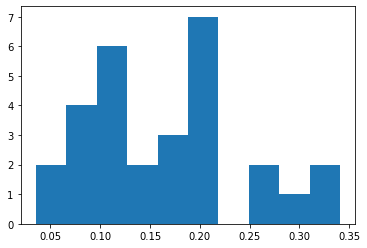

In [450]:
plt.hist(list(centralities.values()))
plt.show()

In [451]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[:10]

[('like', 0.34100124243051977),
 ('think', 0.3345508358573381),
 ('people', 0.3096327817798327),
 ('um', 0.27024599166219254),
 ('know', 0.25767543714677005),
 ('death', 0.21239849990237147),
 ('guess', 0.21239849990237147),
 ('life', 0.21239849990237147),
 ('moral', 0.21239849990237147),
 ('perspective', 0.21239849990237147)]

In [452]:
sorted(centralities.items(), key = lambda x: x[1], reverse = True)[-10:]

[('car', 0.0973132156235257),
 ('cross', 0.0973132156235257),
 ('fast', 0.0973132156235257),
 ('go', 0.0973132156235257),
 ('laugh', 0.07768285141587486),
 ('yea', 0.07768285141587486),
 ('phone', 0.07506819695273652),
 ('maybe', 0.07487564666543949),
 ('punishment', 0.055848140615643825),
 ('uhh', 0.03525623776355326)]

#### Filter by centrality:
We can now filter our network by a centrality measure. Let's define a function and experiment with it:

In [614]:
def filterWords(G, minWeight = 1, filter_ = "betweenness", rule = "number", value_of_rule = 200):
    """Function to filter network by degree centrality measures"""
    G = G.copy()
    try:
        G.remove_edges_from([(n1,n2) for n1, n2, d in G.edges(data = True) if d['weight'] < minWeight])
    except:
        print("weight might be missing from one or more edges")
        raise
    if filter_ =="betweenness":
        index = nx.betweenness_centrality(G) #betweeness centrality score
    elif filter_ == "closeness":
        index = nx.closeness_centrality(G) #closeness centrality score
    elif filter_ == "eigenvector":
        index = nx.eigenvector_centrality(G) #eigenvector centrality score
    elif filter_ == "degree":
        index = nx.degree_centrality(G) #degree centrality score
    else:
        raise ValueError("wrong filter paremeter, should be: betweenness/closeness/eigenvector")    
        
    if rule=='number':# if filter by limiting the total number of nodes 
        
        sorted_index = sorted(index.items(), key=lambda x:x[1], reverse=True)
        value_of_rule = np.min([value_of_rule, len(G.nodes)])
        
        nodes_remain = {}
        for word, centr in sorted_index[:value_of_rule]:
            nodes_remain[word] = centr
        G.remove_nodes_from([n for n in index if n not in nodes_remain])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='above':# if filter by limiting the min value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] >=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G
    
    if rule=='below':# if filter by limiting the max value of centrality
        value_of_rule = np.max([float(value_of_rule),0])
        G.remove_nodes_from([n for n in index if index[n] <=value_of_rule])
        print ("Total number of nodes(after filtering) in the graph is %s" % len(G))
        return G

Let's try eigenvector filtering as follows: only keep nodes which have eigenvector larger than 0.1.

In [618]:
giant_filtered30 = filterWords(giant, minWeight=1, filter_='eigenvector', rule='below', value_of_rule=0.1)
print(nx.info(giant_filtered30))

Total number of nodes(after filtering) in the graph is 19
Name: 
Type: Graph
Number of nodes: 19
Number of edges: 108
Average degree:  11.3684


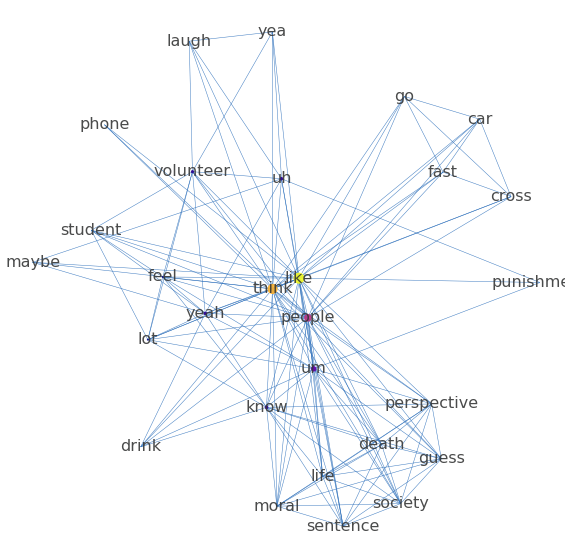

In [617]:
layout_giant_filtered30 = nx.spring_layout(giant_filtered30, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_giant30 = nx.betweenness_centrality(giant_filtered30)
maxC = max(centralities_giant30.items(), key = lambda x : x[1])[1]
nx.draw(giant_filtered30, ax = ax, pos = layout_giant_filtered30, labels = {n: n for n in giant_filtered30.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_giant30[n] / maxC for n in giant_filtered30.nodes],
        node_size = [centralities_giant30[n] / maxC * 100 for n in giant_filtered30.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

#### Global statistics:

1-The density of a network, defined as the number of actual edges divided by the total number of possible edges: the graph is of moderate condense level, 36% of all possible connections.

In [463]:
nx.density(giant)

0.3620689655172414

2-Average degree per node: the average degree centrality is relatively high, 10/29 averaged degree centrality of each code. It might be caused by the 'star' shape connection of the central node 'like', 'think', 'people' which nearly connected with every node in the graph, which increase the average degree centrality of the whole graph.

In [619]:
np.mean([v for w,v in nx.degree(giant)])

10.137931034482758

In [621]:
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 29
Number of edges: 147
Average degree:  10.1379


3-The diameter calculates the average distance between any two nodes in the network: the diameter of the graph is very small, only 2 since this is a closely clustered graph.

In [465]:
nx.diameter(giant)

2

## <span style="color:red">*Exercise 3*</span>

<span style="color:red">Construct cells immediately below this that construct at least two different networks comprising different combinations of word types, linked by different syntactic structures, which illuminate your corpus and the dynamics you are interested to explore. Graph these networks or subnetworks within them. What are relationships that are meaningful? 

<span style="color:red">***Stretch***: Graph some word-centered "ego-networks" with words one link away, two links away, and three links away (we only did up to two links away above).

# POS based networks

Now let's look at links between specific parts of speech within a network.

Let's look at nouns co-occurring in sentences using the top 10 (by score) reddit posts on thread topics we have explored in prior sessions:

In [468]:
df_con.head()

,Unnamed: 0,condition,conversation_txt,con_txt_A,con_txt_B,tokenized_text_all,tokenized_text_A,tokenized_text_B,normalized_token_all,normalized_token_A,normalized_token_B,sentences_all,sentences_A,sentences_B,word_counts
0,0,NB,"Okay, so uh, I guess they said we should start...","Okay, so uh, I guess they said we should start...","Yea, we should start Um, yeah. I actually didn...","[Okay, so, uh, I, guess, they, said, we, shoul...","[Okay, so, uh, I, guess, they, said, we, shoul...","[Yea, we, should, start, Um, yeah, I, actually...","[okay, uh, guess, say, start, yea, start, uh, ...","[okay, uh, guess, say, start, uh, say, topic, ...","[yea, start, um, yeah, actually, look, legal, ...","[[okay, uh, guess, say, start], [yea, start], ...","[[okay, uh, guess, say, start], [uh, say, topi...","[[yea, start, um], [yeah], [actually, look, le...",592
1,1,TYB,"So I don't really I think I said--yes, everyon...","So I don't really I think I said--yes, everyon...",I-I think put something that's below five.. Th...,"[So, I, do, n't, really, I, think, I, said, ye...","[So, I, do, n't, really, I, think, I, said, ye...","[I, I, think, put, something, that, 's, below,...","[think, say, yes, think, oh, okay, uhhm, think...","[think, say, yes, oh, okay, uhhm, think, reaso...","[think, yeah, like, quote, bit, debate, mean, ...","[[], [think, said--], [yes], [i-], [think], [o...","[[], [think, said--], [yes], [oh, okay, uhhm],...","[[], [-i, think], [], [], [yeah, like, quote],...",393
2,2,NB,"Uh, so, uh I-I actually uh read a lot about th...",Ok and so what does the law say? Does it say l...,"Uh, so, uh I-I actually uh read a lot about th...","[Uh, so, uh, I, I, actually, uh, read, a, lot,...","[Ok, and, so, what, does, the, law, say, Does,...","[Uh, so, uh, I, I, actually, uh, read, a, lot,...","[uh, uh, actually, uh, read, lot, topic, uh, u...","[ok, law, like, study, ok, umm, thing, think, ...","[uh, uh, actually, uh, read, lot, topic, uh, u...","[[uh, uh], [-i, actually, uh, read, lot, topic...","[[ok], [law], [like, study], [ok, umm, thing, ...","[[uh, uh], [-i, actually, uh, read, lot, topic...",348
3,3,TYB,Okay so you--What's your opinion on this? I st...,Okay so you--What's your opinion on this? Oh w...,I strongly disagree with this I think you shou...,"[Okay, so, you, What, 's, your, opinion, on, t...","[Okay, so, you, What, 's, your, opinion, on, t...","[I, strongly, disagree, with, this, I, think, ...","[okay, opinion, strongly, disagree, oh, wow--,...","[okay, opinion, oh, wow--, okay, mean, like, c...","[strongly, disagree, think, able, walk, red, l...","[[okay], [opinion], [strongly, disagree], [oh,...","[[okay], [opinion], [oh, wow--], [okay], [], [...","[[strongly, disagree, think, able, walk, red, ...",550
4,4,TYB,"I'm good whenever you are Okay, let's start, y...","Okay, let's start, yea [laugh] Yeah, so um I t...","I'm good whenever you are So I guess like, wha...","[I, 'm, good, whenever, you, are, Okay, let, '...","[Okay, let, 's, start, yea, laugh, Yeah, so, u...","[I, 'm, good, whenever, you, are, So, I, guess...","[m, good, okay, let, start, yea, laugh, guess,...","[okay, let, start, yea, laugh, yeah, um, think...","[m, good, guess, like, wha, wha, think, um, gu...","[[good, okay, let, start, yea, laugh], [guess,...","[[okay, let, start, yea, laugh], [yeah, um, th...","[[good], [guess, like, wha], [-wha], [-what, t...",230


In [622]:
#function to find co-occurance based on POS
def posCooccurrence(sentences, *posType, makeMatrix = False):
    words = set()
    reducedSents = []
    #Only using the first kind of POS for each word
    wordsMap = {}
    for sent in sentences:
        s = [(w, t) for w, t in lucem_illud_2020.spacy_pos(sent) if t in posType]
        for w, t in s:
            if w not in wordsMap:
                wordsMap[w] = t
        reducedSent = [w for w, t in s]
        words |= set(reducedSent)
        reducedSents.append(reducedSent)
    wordLst = list(words)
    wordIndices = {w: i for i, w in enumerate(wordLst)}
    wordCoCounts = {}
    #consider a sparse matrix if memory becomes an issue
    coOcMat = np.zeros((len(wordIndices), len(wordIndices)))
    for sent in reducedSents:
        for i, word1 in enumerate(sent):
            word1Index = wordIndices[word1]
            for word2 in sent[i + 1:]:
                coOcMat[word1Index][wordIndices[word2]] += 1
    if makeMatrix:
        return coOcMat, wordLst
    else:
        coOcMat = coOcMat.T + coOcMat
        g = nx.convert_matrix.from_numpy_matrix(coOcMat)
        g = nx.relabel_nodes(g, {i : w for i, w in enumerate(wordLst)})
        for w in g.nodes:
            g.nodes[w]['bipartite'] = wordsMap[w]
        return g

Build a word to word graph based on Part of Speech: Noun pairs.

In [706]:
gNN = posCooccurrence(df_con['sentences_all'].sum(), 'NN')

In [707]:
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 257
Number of edges: 667
Average degree:   5.1907


And low weight edges:

In [708]:
gNN.remove_edges_from([(n1, n2) for n1, n2, d in gNN.edges(data = True) if d['weight'] <= 2])

In [709]:
gNN.remove_nodes_from([n for n in gNN.nodes if len(set(gNN.neighbors(n))) <= 2]) 
print(nx.info(gNN))

Name: 
Type: Graph
Number of nodes: 10
Number of edges: 17
Average degree:   3.4000


In [711]:
giant = max(connected_component_subgraphs(gNN), key=len) # keep just the giant connected component

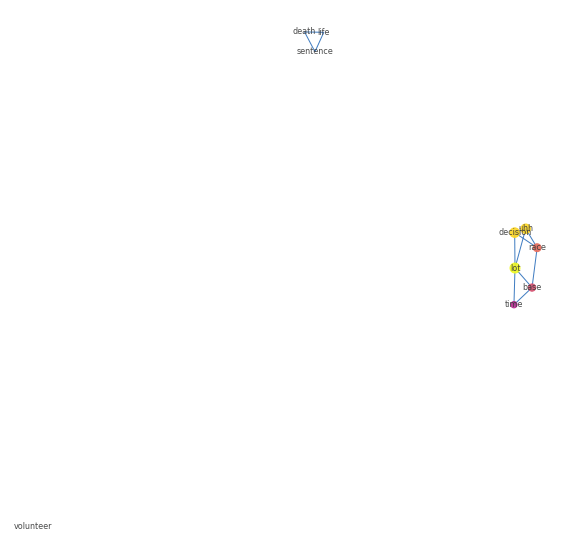

In [714]:
#gNN0=gNN
#gNN=giant
gNN=gNN0
layout_nn = nx.spring_layout(gNN, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nn = nx.eigenvector_centrality(gNN)
maxC = max(centralities_nn.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNN.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNN.edges(data = True)))
nx.draw(gNN, ax = ax, pos = layout_nn, labels = {n: n for n in gNN.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nn[n] / maxC for n in gNN.nodes],
        node_size = [centralities_nn[n] / maxC * 100 for n in gNN.nodes],
        font_size = 8,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

As we could see above, 'life-death-sentece', 'decision-race-base-time' are those common noun pairs, which is corresponding with the conversation topics.

Then we take a look at noun-verb pairs:

In [696]:
gNV = posCooccurrence(df_con['sentences_all'].sum(), 'NN', 'VB')

gNV has co-occurrences between nouns and nouns as well as between verbs and verbs. Let's remove these and make it purely about noun and verb combinations:

In [697]:
gNV.remove_edges_from([(n1,n2) for n1,n2,d in gNV.edges(data = True) if gNV.nodes[n1]['bipartite'] == gNV.nodes[n2]['bipartite']])

In [688]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 312
Number of edges: 471
Average degree:   3.0192


Dropping low weight edges and low degree vertices gives us:

In [698]:
gNV.remove_edges_from([(n1, n2) for n1, n2, d in gNV.edges(data = True) if d['weight'] <= 1])

In [699]:
gNV.remove_nodes_from([n for n in gNV.nodes if len(set(gNV.neighbors(n))) <= 1])

In [700]:
print(nx.info(gNV))

Name: 
Type: Graph
Number of nodes: 29
Number of edges: 34
Average degree:   2.3448


In [701]:
giant = max(connected_component_subgraphs(gNV), key=len) # keep just the giant connected component

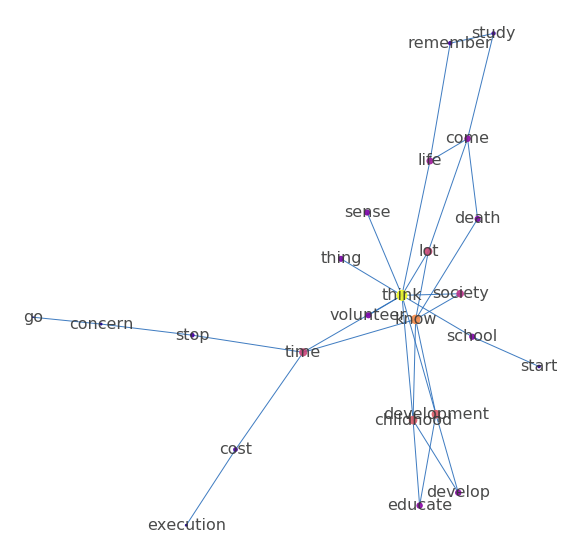

In [703]:
gNV0=gNV
gNV=giant
layout_nn = nx.spring_layout(gNV, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nv = nx.eigenvector_centrality(gNV)
maxC = max(centralities_nv.items(), key = lambda x : x[1])[1]
maxWeight = max((d['weight'] for n1, n2, d in gNV.edges(data = True)))
minWeight = min((d['weight'] for n1, n2, d in gNV.edges(data = True)))
nx.draw(gNV, ax = ax, pos = layout_nn, labels = {n: n for n in gNV.nodes()},
        #width=[(d['weight'] - minWeight + .7) / maxWeight for n1, n2, d in gNN.edges(data = True)], 
        alpha = .9, 
        node_color = [centralities_nv[n] / maxC for n in gNV.nodes],
        node_size = [centralities_nv[n] / maxC * 100 for n in gNV.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       ) 

The noun verb graph revealed common pairs in the diagolue which makes sense (e.g. childhood development, educate/ think a lot etc.) but not very interesting.

Then, create an "ego network" surrounding a single (important) word: for example 'think', which is at the central of the graph.

In [715]:
g_i = gNV.subgraph(['think'] + list(gNV.neighbors('think')))

In [716]:
print(nx.info(g_i))

Name: 
Type: Graph
Number of nodes: 11
Number of edges: 10
Average degree:   1.8182


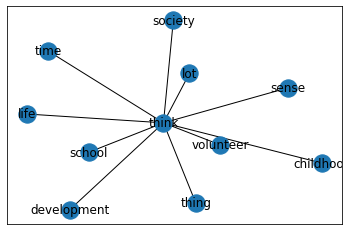

In [717]:
nx.draw_networkx(g_i)

Instead of just nodes connected to a vertex, we can find all those connected to it within 2 hops, lets look at 'look' (+ points for being meta) for this:

In [719]:
storyNeighbors = gNV.neighbors('think')
set(storyNeighbors)

{'childhood',
 'development',
 'life',
 'lot',
 'school',
 'sense',
 'society',
 'thing',
 'time',
 'volunteer'}

In [720]:
storyNeighbors = set(gNV.neighbors('think'))
storyNeighborsPlus1 = set(storyNeighbors)
for n in storyNeighbors:
    storyNeighborsPlus1 |= set(gNV.neighbors(n))

In [721]:
gNV_story = gNV.subgraph(storyNeighborsPlus1)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 19
Number of edges: 25
Average degree:   2.6316


Lets plot it: *the graph expands, beyond the nodes directly connected with 'think', but also linked with nodes connected with 'think' as well.*

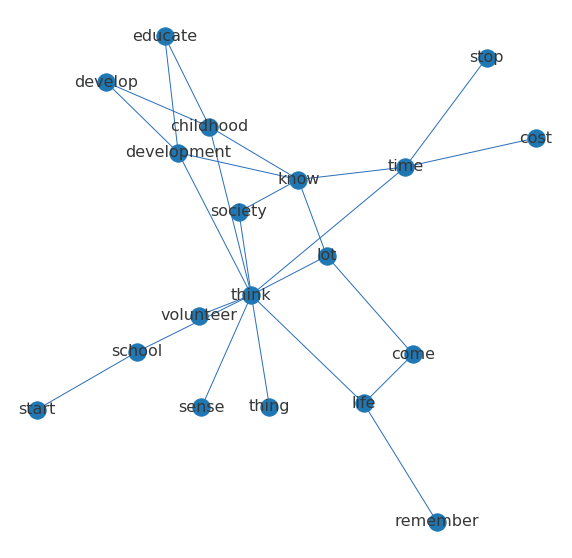

In [722]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

Then, based on the two link away, we expand more, into three links away:

In [726]:
set(storyNeighborsPlus1)

{'childhood',
 'come',
 'cost',
 'develop',
 'development',
 'educate',
 'know',
 'life',
 'lot',
 'remember',
 'school',
 'sense',
 'society',
 'start',
 'stop',
 'thing',
 'think',
 'time',
 'volunteer'}

In [729]:
storyNeighborsPlus2 = set(storyNeighborsPlus1)
for n in storyNeighborsPlus1:
    storyNeighborsPlus2 |= set(gNV.neighbors(n))

In [730]:
gNV_story = gNV.subgraph(storyNeighborsPlus2)
print(nx.info(gNV_story))

Name: 
Type: Graph
Number of nodes: 23
Number of edges: 31
Average degree:   2.6957


Now the graph is more expanded away: *more close to the orginial gNV graph!*

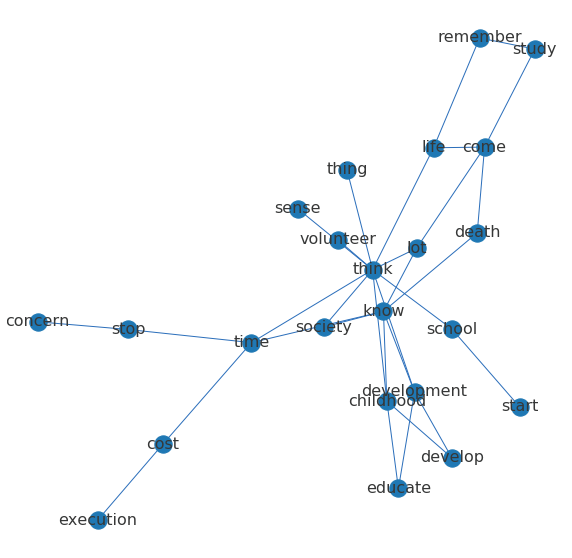

In [731]:
layout_story = nx.spring_layout(gNV_story, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(gNV_story, ax = ax, pos = layout_story, labels = {n: n for n in gNV_story.nodes()},
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
       ) 

Since this is a mid-sized network, but we can interrogate it intelligently by computing some statistics. 

Degree centrality: the most *important* verb-know, think, and the most *important* noun-childhood, development.

In [732]:
sorted(nx.degree_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('think', 0.4545454545454546),
 ('know', 0.2727272727272727),
 ('childhood', 0.18181818181818182),
 ('development', 0.18181818181818182),
 ('time', 0.18181818181818182),
 ('come', 0.18181818181818182),
 ('life', 0.13636363636363635),
 ('lot', 0.13636363636363635),
 ('develop', 0.09090909090909091),
 ('educate', 0.09090909090909091)]

Or eigenvector centrality:

In [733]:
sorted(nx.eigenvector_centrality(gNV_story).items(), key = lambda x: x[1], reverse = True)[:10]

[('think', 0.5220735615943605),
 ('know', 0.37469637706689957),
 ('childhood', 0.30169782833796294),
 ('development', 0.30169782833796294),
 ('lot', 0.26617145559975264),
 ('time', 0.26059366999420763),
 ('society', 0.22543560757613637),
 ('life', 0.18736600025528583),
 ('come', 0.16204220742845482),
 ('develop', 0.15168435971777572)]

Then, lets create a noun-adjective network:

In [734]:
gNJ = posCooccurrence(df_con['sentences_all'].sum(), 'NN', 'JJ')
print(nx.info(gNJ))

Name: 
Type: Graph
Number of nodes: 369
Number of edges: 1296
Average degree:   7.0244


Then visulization based on filtering by a centrality measure we can get a more 'central' set of nodes: 

In [736]:
gNJ_filtered200 = filterWords(gNJ, minWeight=2, filter_='betweenness', rule='number', value_of_rule=25)
print(nx.info(gNJ_filtered200))

Total number of nodes(after filtering) in the graph is 25
Name: 
Type: Graph
Number of nodes: 25
Number of edges: 58
Average degree:   4.6400


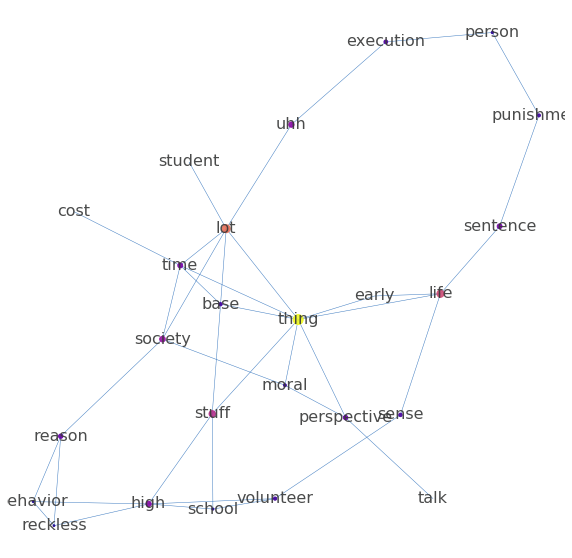

In [737]:
layout_NJ_filtered200 = nx.spring_layout(gNJ_filtered200, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
centralities_nj200 = nx.betweenness_centrality(gNJ_filtered200)
maxC = max(centralities_nj200.items(), key = lambda x : x[1])[1]
nx.draw(gNJ_filtered200, ax = ax, pos = layout_NJ_filtered200, labels = {n: n for n in gNJ_filtered200.nodes()},
        alpha = .9, 
        width = .5,
        node_color = [centralities_nj200[n] / maxC for n in gNJ_filtered200.nodes],
        node_size = [centralities_nj200[n] / maxC * 100 for n in gNJ_filtered200.nodes],
        font_size = 16,
        font_color = 'xkcd:dark grey',
        edge_color = 'xkcd:medium blue',
        cmap = plt.get_cmap('plasma'),
       )

Now interesting adjectives shows up related with nouns, like 'moral', 'early', 'lot', which are related with the topics of the conversation.

## <span style="color:red">*Exercise 4*</span>

<span style="color:red">Construct cells immediately below this that perform a similar social similarity or influence analysis on a dataset relevant to your final project. Create relationships between actors in a network based on your dataset (e.g., person to person or document to document), and perform analyses that interrogate the structure of their interactions, similarity, and/or influence on one another. (For example, if relevant to your final project, you could explore different soap operas, counting how many times a character may have used the word love in conversation with another character, and identify if characters in love speak like each other. Or do opposites attract?) What does that analysis and its output reveal about the relative influence of each actor on others? What does it reveal about the social game being played?

<span style="color:red">Stretch 1:
Render the social network with weights (e.g., based on the number of scenes in which actors appear together), then calculate the most central actors in the show.Realtime output can be viewed in shell.

<span style="color:red">Stretch 2:
Implement more complex measures of similarity based on the papers you have read.

## Creating networks of agents from corpora

Because in our corpora, we do not have multiple actors--only two speaker in a conversation, so for actor-to-actor/agents graph, I will first of all use the soap corpora for this part of analysis (multiple agents):

First of all, load the dataset and organize it into dataframe:

In [296]:
corpora_address ="SOAP"

In [297]:
soap_texts = lucem_illud_2020.loadDavies(corpora_address, num_files=2000)

text_0-tez.zip
text_1-teh.zip
text_2-wts.zip
text_3-pem.zip
text_4-jfy.zip
text_5-rag.zip
text_6-egn.zip
text_7-jss.zip
text_8-sbo.zip
text_9-jtw.zip


In [298]:
import zipfile
zfile = zipfile.ZipFile(corpora_address + "/soap_sources.zip")
source = []
for file in zfile.namelist():
    with zfile.open(file) as f:
        for line in f:
            source.append(line)

Organize the data:

In [299]:
import pandas as pd
soap_dict = {}
for soap in source[3:]:
    try:
        textID, year, show, url = soap.decode("utf-8").split("\t")
    except UnicodeDecodeError:
        continue
    if show.strip() not in soap_dict:
        soap_dict[show.strip()] = []
    if show.strip() in soap_dict:
        try:
            soap_dict[show.strip()].append(soap_texts[textID.strip()])
        except KeyError:
            continue

In [306]:
i=0
soap_df = pd.DataFrame(columns=["Soap Name", "Tokenized Texts"])
for soap in soap_dict:
    # since there were multiple lists
    print(soap)
    full_script = []
    for part in soap_dict[soap]:
        full_script = full_script + part
    soap_df.loc[i] = [soap, full_script]
    i += 1
soap_df

All My Childen
As the World Turns
Bold and Beautiful
Days of Our Lives
General Hospital
Guiding Light
One Life to Live
Passions
Port Charles
Young and Restless


,Soap Name,Tokenized Texts
0,All My Childen,"[@!Liza, You, 're, in, early, @!Ryan, Yeah, I,..."
1,As the World Turns,"[@!Katie, Simon, where, are, you, @!Simon, Kat..."
2,Bold and Beautiful,"[@!Morgan, What, 's, the, matter, Stephanie, Y..."
3,Days of Our Lives,"[@!Philip, Seems, like, every, time, I, look, ..."
4,General Hospital,"[@!Stefan, I, love, her, @!Jax, No, Cassadine,..."
5,Guiding Light,"[@!Reva, Well, it, 's, very, peaceful, Your, b..."
6,One Life to Live,"[@!Rae, What, She, even, has, a, new, friend, ..."
7,Passions,"[@!Kay, Going, to, get, pregnant, and, I, 'm, ..."
8,Port Charles,"[@!Jack, There, you, are, you, son, @!Chris, H..."
9,Young and Restless,"[@!Sharon, Yeah, I, could, n't, sleep, @!Victo..."


Select the soap for further analysis:

In [307]:
dool = soap_df['Tokenized Texts'][3]

In [308]:
' '.join(dool[0:1500])

"@!Philip Seems like every time I look at you tonight you 're crying @!Chloe Tears of happiness I always thought that when I read Tears of Happiness what a crock But tonight you prove to me that they really do exist @!Philip I just carved our initials on that tree @!Chloe But it was so much more than that You took this angry outsider and you made her feel like a girl in a movie or a book a happy movie or a book @!Philip That 's what you deserve to be What gets me is that you do n't even realize how special you are @!Chloe All my life the word special was code for too weird for words And now here you are this great looking guy with a normal life and you make me believe like you really actually want me around @!Philip Oh that 's only half true @!Chloe Oh I 'm sorry @!Philip Oh no Chloe I want you around forever That 's so true but 's not true at all Except for you there 's nothing normal at all about my life @!Brenda We got to get the labs back on 23 @!Woman I 'll grab them @!Brenda Okay

Find the characters and calculate the times of their appearance: 

In [309]:
characters = {}
for token in dool:
    if token[0] == '@':
        # all characters or actions start with @, so we add that to character
        if token[2:] not in characters:
            characters[token[2:]] = 0
        if token[2:] in characters:
            characters[token[2:]] += 1
len(characters)

878

In [310]:
for character in characters:
    if characters[character] > 2000:
        print(character, characters[character])

Philip 2846
Bo 4179
Shawn 2507
Hope 3793
Belle 2518
John 2542
Brady 2265
Marlena 2458
Nicole 2892
Kate 2503
Sami 5462
Lucas 2546


Then draw a graph based on the dialogue between these characters:

In [311]:
actor_network = nx.Graph()
#insert nodes:
for character in characters:
    if characters[character] > 2000:
        actor_network.add_node(character, lines_spoken= characters[character], words=[])
actor_network.nodes.data()

NodeDataView({'Philip': {'lines_spoken': 2846, 'words': []}, 'Bo': {'lines_spoken': 4179, 'words': []}, 'Shawn': {'lines_spoken': 2507, 'words': []}, 'Hope': {'lines_spoken': 3793, 'words': []}, 'Belle': {'lines_spoken': 2518, 'words': []}, 'John': {'lines_spoken': 2542, 'words': []}, 'Brady': {'lines_spoken': 2265, 'words': []}, 'Marlena': {'lines_spoken': 2458, 'words': []}, 'Nicole': {'lines_spoken': 2892, 'words': []}, 'Kate': {'lines_spoken': 2503, 'words': []}, 'Sami': {'lines_spoken': 5462, 'words': []}, 'Lucas': {'lines_spoken': 2546, 'words': []}})

In [312]:
#insert edges based on their conversations:
i = 0
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network.nodes():
                        if (token[2:], token_[2:]) not in actor_network.edges():
                            actor_network.add_edge(token[2:], token_[2:], weight=0)
                        if (token[2:], token_[2:]) in actor_network.edges():
                            actor_network.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network.nodes[token[2:]]['words'].append(dool[i:j])

Visulize the agent network graph:

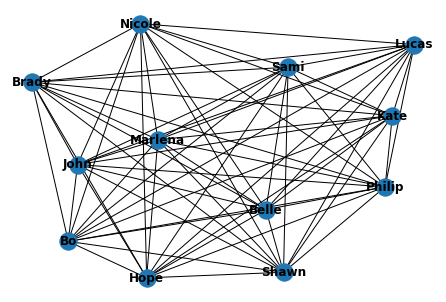

In [313]:
nx.draw(actor_network, with_labels=True, font_weight='bold')

Based on the weight of the edges of the network, we could further plot a heatmap to show their relationship:

Corresponding with the graph above, **Belle** has relative higher connections with the others, also shown in the heatmap; while for **mutual connections**, we could clearly see from the heatmap that: Bo & Hope, Belle & Shawn, Marlena & John, have more mutual conversations.

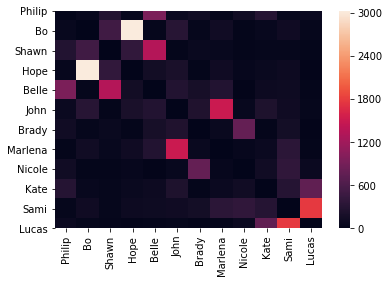

In [314]:
import seaborn as sns
L = []
for node in actor_network.nodes():
    l = []
    for node_ in actor_network.nodes():
        if node == node_:
            l.append(0)
        else:
            l.append(actor_network.edges[(node, node_)]['weight'])
    L.append(l)
M_ = np.array(L)
fig = plt.figure()
div = pandas.DataFrame(M_, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

Then we could also calculate the similarity based on corpora between every two characters:

In [768]:
#functions to calculate divergence
import nltk
def kl_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    D_kl = scipy.stats.entropy(p, q)
    return D_kl

def js_divergence(X, Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    M=(p+q)/2
    D_js=0.5*scipy.stats.entropy(p, M)+0.5*scipy.stats.entropy(q, M)
    return D_js

def chi2_divergence(X,Y):
    P = X.copy()
    Q = Y.copy()
    P.columns = ['P']
    Q.columns = ['Q']
    df = Q.join(P).fillna(0)
    p = df.iloc[:,1]
    q = df.iloc[:,0]
    return scipy.stats.chisquare(p, q).statistic

def Divergence(corpus1, corpus2, difference="KL"):
    """Difference parameter can equal KL, Chi2, or Wass"""
    freqP = nltk.FreqDist(corpus1)
    P = pandas.DataFrame(list(freqP.values()), columns = ['frequency'], index = list(freqP.keys()))
    freqQ = nltk.FreqDist(corpus2)
    Q = pandas.DataFrame(list(freqQ.values()), columns = ['frequency'], index = list(freqQ.keys()))
    if difference == "KL":
        return kl_divergence(P, Q)
    elif difference == "Chi2":
        return chi2_divergence(P, Q)
    elif difference =="JS":
        return js_divergence(P, Q)
    elif difference == "KS":
        try:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency']).statistic
        except:
            return scipy.stats.ks_2samp(P['frequency'], Q['frequency'])
    elif difference == "Wasserstein":
        try:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None).statistic
        except:
            return scipy.stats.wasserstein_distance(P['frequency'], Q['frequency'], u_weights=None, v_weights=None)

In [319]:
#construct the corpora for each character
corpora = []
for character in actor_network.nodes():
    character_words = []
    for sentence in actor_network.nodes[character]['words']:
        for word in sentence:
            character_words.append(word)
    corpora.append(lucem_illud_2020.normalizeTokens(character_words))

In [320]:
#calculate 'similarity' (divergence) based on 'KS'
L = []
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='KS'))
    L.append(l)
M = np.array(L)

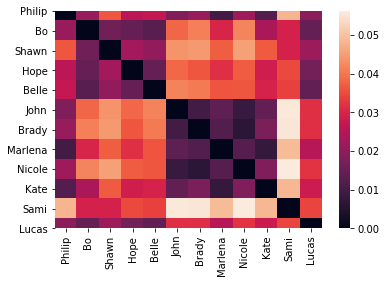

In [321]:
#visualization
fig = plt.figure()
div = pandas.DataFrame(M, columns = list(actor_network.nodes()), index = list(actor_network.nodes()))
ax = sns.heatmap(div)
plt.show()

From the graph above, we could see that Bo & Hope, Belle & Shawn, Marlena & John, who have more conversations with each other, also generally have relatively small divergence score, their corpora more close to each other.

Then we try to build a graph based on characters we speak the word **'love'** to each other, count the times of 'love' spoken between each pair as weights:

In [317]:
actor_network2 = nx.Graph()
for character in characters:
    if characters[character] > 2000:
        actor_network2.add_node(character, lines_spoken= characters[character], words=[])

In [323]:
i=0
for token in dool:
    i += 1
    if i > len(dool):
        break
    if token[0] == "@":
        if token[2:] in actor_network2.nodes():
            j = i
            for token_ in dool[i:]:
                if token_[0] == "@":
                    # if both the characters exist in the graph, add a weight
                    if token_[2:] != token[2:] and token_[2:] in actor_network2.nodes():
                        if 'love' in dool[i:j]:
                            if (token[2:], token_[2:]) not in actor_network2.edges():
                                actor_network2.add_edge(token[2:], token_[2:], weight=0)
                            if (token[2:], token_[2:]) in actor_network2.edges():
                                actor_network2.edges[(token[2:], token_[2:])]['weight'] += 1
                    break
                j += 1
            # adding characters sentences
            actor_network2.nodes[token[2:]]['words'].append(dool[i:j])

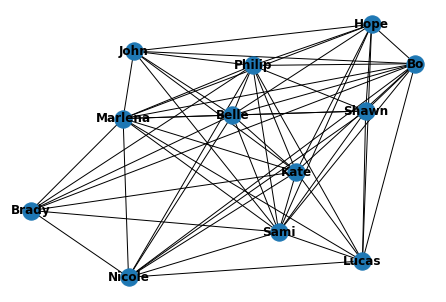

In [324]:
nx.draw(actor_network2, with_labels=True, font_weight='bold')

For the 'love' graph, we could see that 'Belle' and "Philip' pops up in the network. According to wikipedia, they inded have a relationship (while 'mixed') in the show! However, their corpora similarity is moderate, a little more divergent, which is kind of interesting-they are different in expression. 

Also for Philip, he also related with more others in the 'love' graph, compared with the original graph, which might indicate philip's complicated romantic role in this show.

Also for this 'love' character graph, every actor is involved-everyone said at least once love to each other! while 'love' could be used in different settings.

In [739]:
from networkx.algorithms.community import greedy_modularity_communities
c = list(greedy_modularity_communities(actor_network2))

In [740]:
c

[frozenset({'Belle',
            'Bo',
            'Brady',
            'Hope',
            'John',
            'Kate',
            'Lucas',
            'Marlena',
            'Nicole',
            'Philip',
            'Sami',
            'Shawn'})]

#### Then, Back to our Corpora-TYB and NB

Since there is no multi-actor interactions, we could not draw graph based on their direct interaction. However, we could draw graph based on their corpora similarity: level of similairty ('divergence') as edge weights.

First of all, we need to extract the corpora for each agent——A/B speakers in 12 conversations=24 agents:

In [756]:
#extract corpora of each speaker and organize into one list/dataframe
A_cop=[]
A_con=[]
A_wordc=[]
for index, row in df_con.iterrows():
    A_cop.append(row['con_txt_A'])
    A_con.append(row['condition'])
    A_wordc.append(row['word_counts_A'])
    A_cop.append(row['con_txt_B'])
    A_con.append(row['condition'])
    A_wordc.append(row['word_counts_B'])

In [788]:
label=[]
for i in range(12):
    label.append('A_'+str(i+1))
    label.append('B_'+str(i+1))

In [757]:
df_AB=pd.DataFrame({'con_txt':A_cop,'condition':A_con,'label':label,'word_counts':A_wordc})
df_AB.head()

,con_txt,condition,label,word_counts
0,"Okay, so uh, I guess they said we should start...",NB,A_1,181
1,"Yea, we should start Um, yeah. I actually didn...",NB,B_1,58
2,"So I don't really I think I said--yes, everyon...",TYB,A_2,118
3,I-I think put something that's below five.. Th...,TYB,B_2,26
4,Ok and so what does the law say? Does it say l...,NB,A_3,37


Then, build a 2-mode (agent-word) graph first:

In [746]:
senVects_incidence = senVectorizer.fit_transform(df_AB['con_txt'])

In [747]:
senVects_incidence.shape

(24, 583)

In [748]:
g_2mode = nx.Graph()

#define all the nodes
g_2mode.add_nodes_from((senVectorizer.get_feature_names()[i] for i in range(senVects_incidence.shape[1])), bipartite = 'word')
g_2mode.add_nodes_from(range(senVects_incidence.shape[0]), bipartite = 'doc')

#add all the edges
g_2mode.add_edges_from(((d, senVectorizer.get_feature_names()[w], {'weight' : senVects_incidence[d, w]}) for d, w in zip(*senVects_incidence.nonzero())))

In [749]:
print(nx.info(g_2mode))

Name: 
Type: Graph
Number of nodes: 607
Number of edges: 1132
Average degree:   3.7298


Remove edges and isolated nodes, and find most connected subgraphs for visualization:

In [750]:
g_2mode.remove_edges_from([(n1, n2) for n1, n2, d in g_2mode.edges(data = True) if d['weight'] <= 5])

In [751]:
g_2mode.remove_nodes_from(list(nx.isolates(g_2mode))) #since we are changing the graph list() evaluates the isolates first

In [752]:
giant = max(connected_component_subgraphs(g_2mode), key=len) # keep just the giant connected component
print(nx.info(giant))

Name: 
Type: Graph
Number of nodes: 33
Number of edges: 42
Average degree:   2.5455


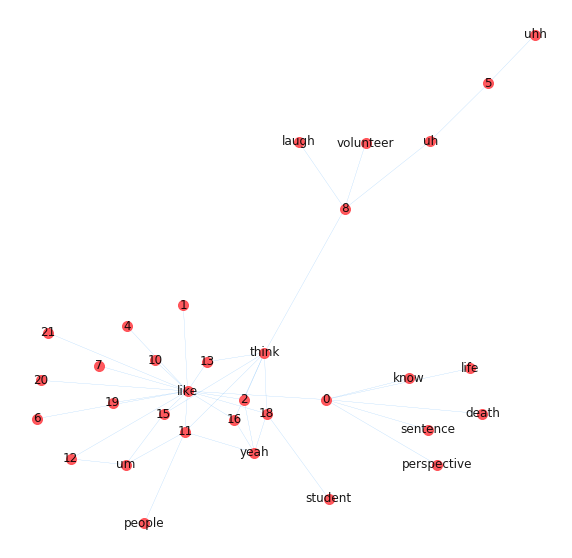

In [753]:
layout = nx.spring_layout(giant, weight='weight', iterations= 100)
fig, ax = plt.subplots(figsize = (10,10))
nx.draw(giant, ax = ax, pos = layout, labels = {n:n for n in giant.nodes()},
        width=.2, 
        alpha = .9, 
        node_size = 100,
        node_color = "xkcd:light red",
        edge_color='xkcd:sky blue') #Getting labels is a bit annoying

As we could see most agents corpora were clustered together, centering around the filer words 'like', while a few actors 5/8 are far away. The reason I guess might because for these agents, they spoke less 'like' filter words in their expression, and generally expressed differently compared with the other actors.

In [758]:
df_AB

,con_txt,condition,label,word_counts
0,"Okay, so uh, I guess they said we should start...",NB,A_1,181
1,"Yea, we should start Um, yeah. I actually didn...",NB,B_1,58
2,"So I don't really I think I said--yes, everyon...",TYB,A_2,118
3,I-I think put something that's below five.. Th...,TYB,B_2,26
4,Ok and so what does the law say? Does it say l...,NB,A_3,37
5,"Uh, so, uh I-I actually uh read a lot about th...",NB,B_3,114
6,Okay so you--What's your opinion on this? Oh w...,TYB,A_4,80
7,I strongly disagree with this I think you shou...,TYB,B_4,99
8,"Okay, let's start, yea [laugh] Yeah, so um I t...",TYB,A_5,84
9,"I'm good whenever you are So I guess like, wha...",TYB,B_5,22


Then we transfer into one-mode agents network:

In [564]:
#transfer into a one-mode network
def contractNetwork(g, targetType):
    g_mono = nx.Graph()
    g_mono.add_nodes_from(((n, d) for n, d in g_2mode.nodes(data = True) if d['bipartite'] == targetType))
    
    for n_outside in (n for n, d in g_2mode.nodes(data = True) if d['bipartite'] != targetType):
        neighbors = list((n for n in g.neighbors(n_outside) if g.nodes[n]['bipartite'] == targetType))
        for i, n1 in enumerate(neighbors):
            for n2 in neighbors[i+1:]:
                try:
                    g_mono.edges[n1, n2]['weight'] += 1
                except KeyError:
                    g_mono.add_edge(n1, n2, weight = 1)
    return g_mono

In [759]:
gDoc = contractNetwork(g_2mode, 'doc')
print(nx.info(gDoc))

Name: 
Type: Graph
Number of nodes: 18
Number of edges: 127
Average degree:  14.1111


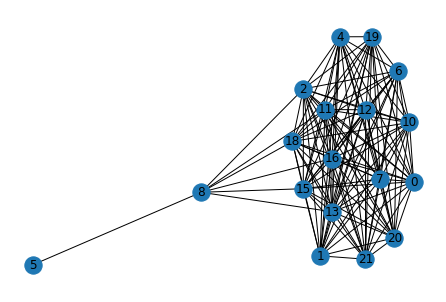

In [567]:
layout = nx.spring_layout(gDoc, k = 1/3, weight='weight', iterations= 50)
nx.draw(gDoc, pos = layout, labels = {n:n for n in gDoc.nodes()}) #Getting labels is a bit annoying

As shown above, more clearly, agent 5(B_3) and 8(A_5) stands out in the corpora who both speak more 'um, uh'; while there is no clear relaitonship about conditions (TYB-2,3,6-11,16-21), or pairs (only 20,21,A/B_11,are connected to each other based on words co-occurence)

In [761]:
df_AB['con_txt'][5]

"Uh, so, uh I-I actually uh read a lot about this topic, and, uh uh but from my understanding, um there is a very strong legal case like-- uh being blind to a candidate's race to a large extent is necessary under uhh decisions, uhh relevant decisions from the Supreme Court and other and there are a current cases working through the court system uhh with the aim of uh clarifying that decision. And uhh I think the primary consideration should be uhh that the Ivy League institution being uhh recipients of federal funding must follow the law. So so the I believe it is part of the Civil Rights Act, that states any institution receiving federal funding um must not differentiate discriminate based on like race or uh color or nationality or gender I think. And this is part of like uhh the civil rights act, which is obviously uhh a very important part of uh of the American legal system. So, this is the primary consideration. Well, that is, umm, that is possible, but there are numerous methods t

In [762]:
df_AB['con_txt'][8]

"Okay, let's start, yea [laugh] Yeah, so um I think uhhh we should not be required [laugh] to volunteer uh because I think volunteer by nature is self growing. So, some students might not uh have the intention to do so if they are required to so they might be reluctant [laugh] Yeah, I do think those are the benefits of um volunteering. I think especially for me, uhh like you said, I'm very easy to get only focused on on schoolwork [laugh], and I couldn't care about the environment that much. And yeah, so um I think probably, uh when we're uh required to do volunteers, I think is more efficient and beneficial if we can uh have a real sense of what we can do like specifically, for example, we can apply uh what we learn at schools to uh volunteering. And instead of just, uh choosing whatever that seems like uh volunteer stuff, like at my high school [laugh], uh everyone just does the same thing and it's very pretty yea. Oh yea, [laugh] Yea, okay."

In [760]:
df_AB

,con_txt,condition,label,word_counts
0,"Okay, so uh, I guess they said we should start...",NB,A_1,181
1,"Yea, we should start Um, yeah. I actually didn...",NB,B_1,58
2,"So I don't really I think I said--yes, everyon...",TYB,A_2,118
3,I-I think put something that's below five.. Th...,TYB,B_2,26
4,Ok and so what does the law say? Does it say l...,NB,A_3,37
5,"Uh, so, uh I-I actually uh read a lot about th...",NB,B_3,114
6,Okay so you--What's your opinion on this? Oh w...,TYB,A_4,80
7,I strongly disagree with this I think you shou...,TYB,B_4,99
8,"Okay, let's start, yea [laugh] Yeah, so um I t...",TYB,A_5,84
9,"I'm good whenever you are So I guess like, wha...",TYB,B_5,22


Then we could more directly calculate the distances between two agents' corpora:

In [773]:
#organize the corpora for 24 agents
AB_cop_token=[]
for index, row in df_con.iterrows():
    AB_cop_token.append(row['normalized_token_A'])
    AB_cop_token.append(row['normalized_token_B'])

In [779]:
#calculate divergence distance based on JS
L=[]
corpora=AB_cop_token
for p in corpora:
    l = []
    for q in corpora:
        l.append(Divergence(p,q, difference='JS'))
    L.append(l)
M = np.array(L)

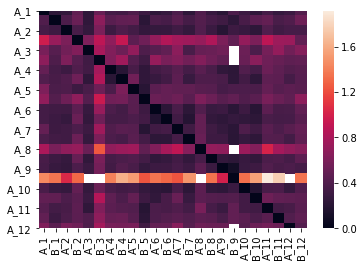

In [780]:
#plot the divergence
fig = plt.figure()
div = pd.DataFrame(M, columns = label, index =label)
ax = sns.heatmap(div)
plt.show()

As we could see above, most pairs seemed to speak relatively close to each other, except for B_9, who have very few words spoken(4) and A_8, who also have fewer words spoken (29).
To better figure out the effect of condition and paris, we do an aggregated descriptive statistic analysis:

In [784]:
#organized and aggregated the distance between conditions and also by A/B
sim_TYB,sim_TYB_A,sim_TYB_B=[],[],[]
sim_NB,sim_NB_A,sim_NB_B=[],[],[]

for i in range(24):
    for j in range(i+1,24):
        if df_AB['condition'][i]=='TYB'and df_AB['condition'][j]=='TYB':
            sim_TYB.append(float(M[i,j]))
            if df_AB['label'][i][0]=='A'and df_AB['label'][j][0]=='A':
                sim_TYB_A.append(float(M[i,j]))
            if df_AB['label'][i][0]=='B'and df_AB['label'][j][0]=='B':
                sim_TYB_B.append(float(M[i,j]))    
        if df_AB['condition'][i]=='NB'and df_AB['condition'][j]=='NB':
            sim_NB.append(float(M[i,j]))
            if df_AB['label'][i][0]=='A'and df_AB['label'][j][0]=='A':
                sim_NB_A.append(float(M[i,j]))
            if df_AB['label'][i][0]=='B'and df_AB['label'][j][0]=='B':
                sim_NB_B.append(float(M[i,j]))

In [785]:
#show the averaged distance between conditions and by pairs
avg_sim_TYB=sum(sim_TYB)/len(sim_TYB)
avg_sim_TYB_A=sum(sim_TYB_A)/len(sim_TYB_A)
avg_sim_TYB_B=sum(sim_TYB_B)/len(sim_TYB_B)
print('Avg divergence of TYB',round(avg_sim_TYB,4))
print('Avg divergence of TYB-A',round(avg_sim_TYB_A,4))
print('Avg divergence of TYB-B',round(avg_sim_TYB_B,4))
print('')

avg_sim_NB=sum(sim_NB)/len(sim_NB)
avg_sim_NB_A=sum(sim_NB_A)/len(sim_NB_A)
avg_sim_NB_B=sum(sim_NB_B)/len(sim_NB_B)
print('Avg divergence of NB',round(avg_sim_NB,4))
print('Avg divergence of NB-A',round(avg_sim_NB_A,4))
print('Avg divergence of NB-B',round(avg_sim_NB_B,4))

Avg divergence of TYB 0.4506
Avg divergence of TYB-A 0.3581
Avg divergence of TYB-B 0.5833

Avg divergence of NB 0.461
Avg divergence of NB-A 0.4675
Avg divergence of NB-B 0.4736


As we could see, the averaged distance of dialogue between TYB and NB condition is pretty close. While in TYB condition, Person A has more close dialogues (being trained to say 'Thank you because'?);in NB condition,the difference between Person A and B is very small. This result is very interesting and should be examined further.

To more clearly show the trend, let's plot the result in a bar graph: 

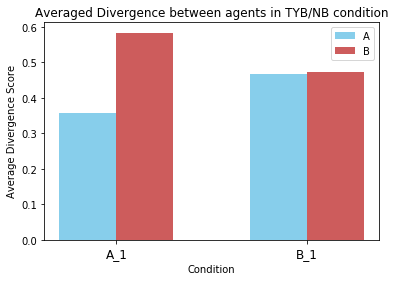

In [789]:
#Plot bar graph to more clearly 
label2=['TYB','NB']
index=np.arange(len(label2))
width=0.3

mean1=[avg_sim_TYB_A,avg_sim_NB_A]
mean2=[avg_sim_TYB_B,avg_sim_NB_B]

plt.bar(index,mean1,width,color='SkyBlue',label='A') 
plt.bar(index+width,mean2,width,color='IndianRed',label='B')

plt.xlabel('Condition')
plt.ylabel('Average Divergence Score')
plt.xticks(index+width/2,label,FontSize=12)
plt.legend()
plt.title('Averaged Divergence between agents in TYB/NB condition');

Then for similarity of two agents in pairs: we could find that pairs in TYB condition has much lower distance (0.23) in between compared with NB condition (0.49), which is very interesting and corresponding to all prediciton.

In [808]:
#pair similarity
sim_pair_TYB,sim_pair_NB=[],[]
for i in range(12):
    if df_AB['condition'][2*i]=='TYB':
        sim_pair_TYB.append(float(M[2*i,2*i+1]))
    if df_AB['condition'][2*i]=='NB':
        sim_pair_NB.append(float(M[2*i,2*i+1]))    

In [809]:
avg_sim_pair_TYB=sum(sim_pair_TYB)/len(sim_pair_TYB)
avg_sim_pair_NB=sum(sim_pair_NB)/len(sim_pair_NB)
print('Avg divergence of pair in TYB',round(avg_sim_pair_TYB,4))
print('Avg divergence of pair in NB',round(avg_sim_pair_NB,4))

Avg divergence of pair in TYB 0.2302
Avg divergence of pair in NB 0.4945


#### Draw agents network based on divergence/similarity:

While we could not derive influence matrix, the degree of similarity/divergence could also be visualized by network as well.So we will then drawt the network graph based on mutual distance/similarity.

In [794]:
#organize the divergence matrix into a dataframe
df_M=pd.DataFrame(M,index=label,columns=label)
df_M.dropna(inplace=True)
df_M

,A_1,B_1,A_2,B_2,A_3,B_3,A_4,B_4,A_5,B_5,...,A_8,B_8,A_9,B_9,A_10,B_10,A_11,B_11,A_12,B_12
A_1,0.000000,0.226540,0.256215,0.477658,0.236946,0.513808,0.347970,0.330200,0.391409,0.305889,...,0.402494,0.278829,0.215621,0.386727,0.304710,0.244032,0.349658,0.275093,0.306582,0.416550
B_1,0.398345,0.000000,0.387228,0.523746,0.244225,0.678029,0.447692,0.486344,0.493658,0.217193,...,0.416021,0.352760,0.318053,0.232178,0.364009,0.454282,0.493512,0.371389,0.397117,0.534303
A_2,0.346746,0.307923,0.000000,0.364786,0.264836,0.600573,0.311979,0.389907,0.343882,0.256077,...,0.410288,0.299080,0.194964,0.310862,0.283631,0.237153,0.409052,0.326021,0.358236,0.356127
B_2,0.973313,0.718711,0.603475,0.000000,0.613564,0.891666,0.685277,0.930114,0.458274,0.540575,...,0.711139,0.823717,0.600210,0.483074,0.706255,0.606209,0.892832,0.742257,0.733732,0.481675
A_4,0.497819,0.346474,0.301252,0.402715,0.333623,0.780631,0.000000,0.208089,0.363660,0.245521,...,0.445542,0.373776,0.251906,0.228807,0.409314,0.345787,0.524496,0.467413,0.415519,0.435326
B_4,0.409194,0.363422,0.398717,0.541888,0.240384,0.845280,0.214061,0.000000,0.551001,0.244484,...,0.391658,0.394842,0.370638,0.232178,0.336336,0.233786,0.466552,0.460364,0.351341,0.432482
A_5,0.612102,0.377940,0.392612,0.311441,0.373953,0.535197,0.377121,0.603982,0.000000,0.203230,...,0.441128,0.429915,0.354234,0.386329,0.386565,0.381572,0.497547,0.429393,0.456974,0.437947
B_5,0.693674,0.419103,0.533577,0.682431,0.421055,0.951228,0.546527,0.565183,0.444914,0.000000,...,0.607379,0.528511,0.435015,0.483074,0.397692,0.445932,0.590173,0.516872,0.464352,0.678086
A_6,0.343340,0.327404,0.318437,0.461048,0.276962,0.719339,0.383274,0.337269,0.439517,0.309119,...,0.410586,0.287337,0.300092,0.221347,0.307305,0.203520,0.460933,0.366244,0.367327,0.482072
B_6,0.338090,0.301642,0.276488,0.516536,0.255916,0.541556,0.346486,0.346872,0.387405,0.335641,...,0.487497,0.261253,0.234046,0.271787,0.247158,0.225239,0.371918,0.345214,0.355563,0.441379


In [791]:
#draw network based on divergence matrix
def drawNetwork(df,title):
    fig = plt.figure(figsize=[8,8])
    G = nx.DiGraph()
    for from_ in df.index:
        for to_ in df.columns:
            G.add_edge(from_,to_,weight = df.loc[from_][to_])
            
    pos = nx.spring_layout(G,k=0.55,iterations=20)
    edges,weights = zip(*nx.get_edge_attributes(G,'weight').items())
    weights = np.array(weights)
    #weights = weights*weights
    weights = 6*weights/np.max(weights)
    print(title)
    
    edge_colors=20*(weights/np.max(weights))
    edge_colors = edge_colors.astype(int)
#     nx.draw_networkx_nodes(G,pos,node_size=1200,alpha=0.7,node_color='#99cef7')
#     nx.draw_networkx_edges(G,pos,edge_color=edge_colors)
#     nx.draw_networkx_labels(G,pos,font_weight='bold')
    nx.draw(G,pos,with_labels=True, font_weight='bold',width=weights,\
            edge_color=255-edge_colors,node_color='#99cef7',node_size=1200,\
            alpha=0.75,arrows=True,arrowsize=20)
    return edge_colors

Divergence Network


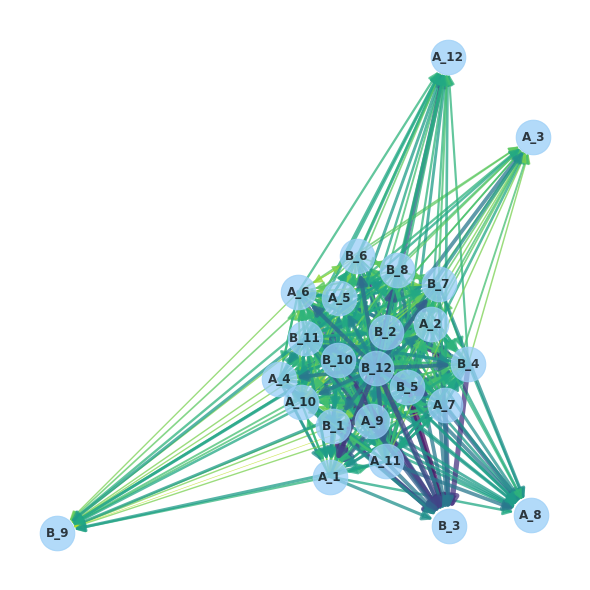

In [795]:
G_mean = drawNetwork(df_M,'Divergence Network')

As we could see above, this is the divergence graph based on divergence score, higher value/thicker arrow indicates more far away their corpora is;while there are arrows in this graph, they are mutual relationship, since the distance score is computed as mutual divergence and for each pair the score is non-directional. 

Therefore, we take an inverse to get the similarity matrix: 

In [805]:
import math
M0=np.zeros((24,24))
for i in range(24):
    for j in range(24):
        if i!=j:
            a=1/M[i,j]
            if not math.isnan(a):
                M0[i,j]=1/M[i,j]
df_M0=pd.DataFrame(M0,index=label,columns=label)
#df_M0.dropna(inplace=True)
df_M0

,A_1,B_1,A_2,B_2,A_3,B_3,A_4,B_4,A_5,B_5,...,A_8,B_8,A_9,B_9,A_10,B_10,A_11,B_11,A_12,B_12
A_1,0.000000,4.414231,3.902974,2.093547,4.220379,1.946252,2.873810,3.028472,2.554872,3.269157,...,2.484508,3.586429,4.637776,2.585803,3.281806,4.097831,2.859938,3.635140,3.261775,2.400670
B_1,2.510387,0.000000,2.582457,1.909322,4.094589,1.474864,2.233676,2.056157,2.025696,4.604203,...,2.403725,2.834789,3.144129,4.307034,2.747182,2.201276,2.026295,2.692592,2.518148,1.871598
A_2,2.883959,3.247561,0.000000,2.741331,3.775921,1.665077,3.205342,2.564716,2.907973,3.905069,...,2.437309,3.343590,5.129152,3.216859,3.525710,4.216695,2.444675,3.067285,2.791459,2.807987
B_2,1.027419,1.391379,1.657068,0.000000,1.629822,1.121496,1.459265,1.075137,2.182099,1.849884,...,1.406194,1.214008,1.666082,2.070077,1.415919,1.649595,1.120031,1.347243,1.362896,2.076090
A_3,1.696120,2.314304,1.798502,1.599123,0.000000,1.253273,1.603786,1.858892,1.429971,2.565138,...,1.975574,1.922655,1.822980,0.000000,1.908220,2.610648,1.757277,1.414119,1.828879,1.562650
B_3,1.472784,2.546990,1.636049,2.314189,3.103274,0.000000,1.617091,1.311906,2.373074,3.120508,...,1.583115,1.853913,2.068362,0.000000,1.940518,1.509431,1.843958,1.976853,2.144855,2.081664
A_4,2.008763,2.886217,3.319484,2.483147,2.997400,1.281015,0.000000,4.805628,2.749823,4.072977,...,2.244459,2.675397,3.969727,4.370489,2.443114,2.891958,1.906593,2.139434,2.406629,2.297130
B_4,2.443831,2.751624,2.508047,1.845398,4.160009,1.183040,4.671566,0.000000,1.814879,4.090252,...,2.553247,2.532657,2.698047,4.307034,2.973215,4.277415,2.143384,2.172195,2.846238,2.312233
A_5,1.633714,2.645923,2.547045,3.210884,2.674135,1.868471,2.651669,1.655678,0.000000,4.920523,...,2.266914,2.326040,2.822996,2.588467,2.586889,2.620738,2.009861,2.328867,2.188310,2.283382
B_5,1.441600,2.386051,1.874145,1.465349,2.374988,1.051273,1.829736,1.769337,2.247626,0.000000,...,1.646420,1.892107,2.298769,2.070077,2.514508,2.242495,1.694418,1.934714,2.153539,1.474739


Similarity Network


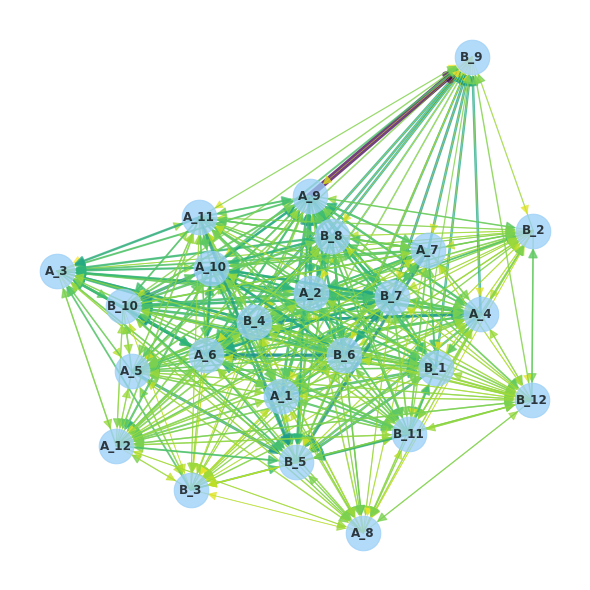

In [806]:
G_mean = drawNetwork(df_M0,'Similarity Network')

From the above similarity graph, we could see that 1) for pairs: many paris have higher similarity in between (for example, A_6-B_6, A_4-B_4), while the color is very similar and is hard to distinguish; 2) For condition, TYB(2,4-6,9-11)condition seems have higher similarity in pairs; 3) B_5 and A_3 seems to be very close to the other agents' corpora which is very interesting. 

In [807]:
df_AB['con_txt'][9] #B_5 it seems there are more words for expression opinion, maybe that is very it is very similar to other agents' corpora?

"I'm good whenever you are So I guess like, wha-wha-what do you think about um, I guess this question? Gotcha. Yeah, I didn't like have like volunteering in high school.  But yea I think a lot of people would benefit from that. "

In [799]:
df_AB

,con_txt,condition,label,word_counts
0,"Okay, so uh, I guess they said we should start...",NB,A_1,181
1,"Yea, we should start Um, yeah. I actually didn...",NB,B_1,58
2,"So I don't really I think I said--yes, everyon...",TYB,A_2,118
3,I-I think put something that's below five.. Th...,TYB,B_2,26
4,Ok and so what does the law say? Does it say l...,NB,A_3,37
5,"Uh, so, uh I-I actually uh read a lot about th...",NB,B_3,114
6,Okay so you--What's your opinion on this? Oh w...,TYB,A_4,80
7,I strongly disagree with this I think you shou...,TYB,B_4,99
8,"Okay, let's start, yea [laugh] Yeah, so um I t...",TYB,A_5,84
9,"I'm good whenever you are So I guess like, wha...",TYB,B_5,22
